## Predict tomato shapes from DNA
- take as causative snps the different tomato analyzer metrics + GBS snps + random snps
- generate additional images using an additive interpolation between parent images

Requires from preparation script
- data/TraditomContours.pkl
- data/TraditomGpred.txt: contains OLS estimates of phenotype / tomato analyzer metrics
- data/TraditomGBS.txt


In [1]:
# check library version numbers 
import os, glob
import numpy as np
print('numpy: %s' % np.__version__) 
import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: %s' % matplotlib.__version__)
import random
import seaborn as sns
import skimage
import scipy
import plotly
import PIL
from PIL import Image, ImageDraw, ImageFilter
import cv2
print('opencv: %s' % cv2.__version__)
print('PIL: %s' % PIL.__version__)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle

numpy: 1.22.4
matplotlib: 3.4.3
opencv: 4.5.1
PIL: 8.3.2


In [2]:
# DL modules
# tensorflow
import tensorflow as tf
print('tensorflow: %s' % tf.__version__)
# keras
from tensorflow import keras
print('keras: %s' % keras.__version__)
from tensorflow.keras import layers
import kerastuner as kt
print('kerastuner: %s' % kt.__version__)
from tensorflow.python.keras import backend as K

tensorflow: 2.4.1
keras: 2.4.0
kerastuner: 1.0.2


In [15]:
# standard decoder dna --> image
# generates images out of snp data
def dna2image(n_snp,image_size):
    input = tf.keras.layers.Input(shape=(n_snp))
    initializer = tf.keras.initializers.GlorotNormal()

    x = tf.keras.layers.Dense(np.prod(image_size), kernel_initializer=initializer)(input)
    x = tf.keras.layers.Reshape(image_size+(1,))(x)
    x = tf.keras.layers.Conv2DTranspose(16, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(8, (3,3), activation='relu', padding='same')(x)
 
    output = tf.keras.layers.Conv2DTranspose(1, (5,5), activation='relu', padding='same')(x)

    return tf.keras.Model(input, output)

In [16]:
# generate cropped and resized images from contours
def crop(c, max_box=(225, 973, 2283, 2494), insize=(3507, 2481), outsize=(128,128), slack=20):
    imw = np.zeros(insize)
    cv2.drawContours(imw, c, -1, (255,255,255), 5)
    cv2.fillPoly(imw, [c], (255,255,255))
    # crop
    x0,y0,x1,y1 = max_box
    imw = imw[y0-slack:y1+slack, x0-slack:x1+slack]
    # resize
    #imw = cv2.resize(imw, outsize, cv2.IMREAD_UNCHANGED)
    imw = cv2.resize(imw, outsize, interpolation = cv2.INTER_AREA)
    return imw

In [17]:
# function to plot a sample (n=5) of observed vs predicted fruits
def plot_obs_exp(dna, imgs, model, n=5):
    ilist = np.random.randint(0,dna.shape[0], n)
    image_size = imgs.shape[1:3]
    plt.figure(figsize=(15, 15))
    for i,ind in enumerate(ilist):
        ax = plt.subplot(5, 5, 1+i)
        plt.imshow(imgs[ind,])
        plt.title('Observed:'+str(ind))
        plt.axis("off")
    for i,id in enumerate(ilist):
        ax = plt.subplot(5, 5, 6+i)
        g = tf.expand_dims(dna[id,:], 0)
        img = model.predict(g).reshape(image_size)
        plt.imshow(img)
        plt.title('Predicted:'+str(id))
        plt.axis("off")

In [5]:
# read contours
ind_contours = pickle.load(open('data/TraditomContours.pkl', 'rb'))

In [8]:
# # total no. images
n=0
for _ in ind_contours:
    n+=len(ind_contours[_])
n

353

In [9]:
# read pedigree
ped = pd.read_csv('data/TraditomPedigree.txt', sep='\t')

# how many parental and maternal lines
print('N females',len(pd.unique(ped['Female']))-1)
print('N males',len(pd.unique(ped['Male']))-1)

N females 25
N males 7


In [11]:
# read 'causative' QTNs (tomato anayzer metrics)
qtn = pd.read_csv('data/TraditomGpred.txt', header=None, sep=' ')

# read GBS genotypes in ped order
gbs = np.array(pd.read_csv('data/TraditomGBS.txt', header=None, sep=' '))

# first col is individual
n_snp = qtn.shape[1]-1 + gbs.shape[1]


In [12]:
# generate qtn + imgset, 
image_size = (128,128) 
dnaset = []
imgset1 = []
for i,ind in enumerate(ped['Ind']):
    # skip first column
    q = np.array(qtn.loc[qtn[0]==ind])[0,1:]
    # gbs
    q = np.concatenate((q,gbs[i,:]),axis=0)
    for ci in ind_contours[ind]:
        dnaset.append(q)
        imgset1.append(crop(ci))

dnaset = np.asarray(dnaset, dtype='float32')
imgset1 = np.asarray(imgset1, dtype='float32')
n_snp = dnaset.shape[1]


In [13]:
# split data
dna_train, dna_val, imgs_train, imgs_val = train_test_split(dnaset, imgset1, test_size=0.2)


In [18]:
# RMSprop, Adamax, SGD=caca
if 'decoder' in locals() or 'decoder' in globals(): del decoder

decoder = dna2image(n_snp,image_size)

decoder.compile(optimizer=keras.optimizers.RMSprop(1e-3, centered=True),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=tf.keras.metrics.MeanSquaredError(), )

decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 116)]             0         
_________________________________________________________________
dense (Dense)                (None, 16384)             1916928   
_________________________________________________________________
reshape (Reshape)            (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 128, 128, 16)      160       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 8)       1160      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 1)       201       
Total params: 1,918,449
Trainable params: 1,918,449
Non-trainable params: 0
___________________________________________________

In [19]:
epochs = 30

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=3),]

decoder.fit(x=dna_train,
            y=imgs_train,
            batch_size=12, 
            callbacks=callbacks, 
            epochs=epochs,
            validation_data=(dna_val,imgs_val),)

Epoch 1/30
24/24 [==============================] - 5s 149ms/step - loss: 9642.4221 - mean_squared_error: 9642.4230 - val_loss: 5411.5200 - val_mean_squared_error: 5411.5200
Epoch 2/30
24/24 [==============================] - 3s 139ms/step - loss: 4817.8394 - mean_squared_error: 4817.8394 - val_loss: 2519.2065 - val_mean_squared_error: 2519.2065
Epoch 3/30
24/24 [==============================] - 3s 133ms/step - loss: 2453.0530 - mean_squared_error: 2453.0530 - val_loss: 1717.4197 - val_mean_squared_error: 1717.4197
Epoch 4/30
24/24 [==============================] - 3s 129ms/step - loss: 1707.7039 - mean_squared_error: 1707.7039 - val_loss: 1431.0759 - val_mean_squared_error: 1431.0759
Epoch 5/30
24/24 [==============================] - 3s 135ms/step - loss: 1256.7809 - mean_squared_error: 1256.7809 - val_loss: 1186.4563 - val_mean_squared_error: 1186.4563
Epoch 6/30
24/24 [==============================] - 3s 121ms/step - loss: 1159.4328 - mean_squared_error: 1159.4328 - val_loss: 11

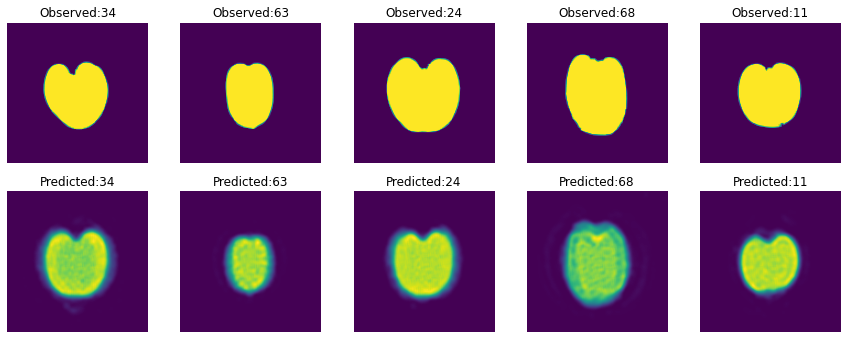

In [20]:
plot_obs_exp(dna_val, imgs_val, decoder, n=5)


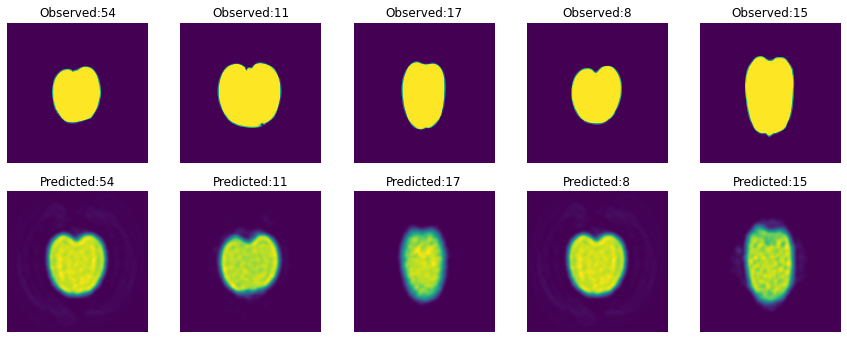

In [21]:
plot_obs_exp(dna_val, imgs_val, decoder, n=5)
